In [1]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import math

In [2]:
df = pd.read_csv(r"C:\Users\Nimish\Downloads\archive\uber.csv")
print("Shape:", df.shape)
print("Columns:", list(df.columns))
display(df.head())

Shape: (200000, 9)
Columns: ['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
cols = df.columns.str.lower()
def find(colname):
    for c in df.columns:
        if colname in c.lower():
            return c
    return None

In [4]:
fare_col = find("fare")
pickup_lat = find("pickup_lat")
pickup_lon = find("pickup_lon") or find("pickup_long") or find("pickup_longitude")
dropoff_lat = find("dropoff_lat")
dropoff_lon = find("dropoff_lon") or find("dropoff_long") or find("dropoff_longitude")
pass_col = find("pass") or find("passenger")

In [5]:
print("\nDetected columns:")
print("fare:", fare_col)
print("pickup_lat:", pickup_lat, "pickup_lon:", pickup_lon)
print("dropoff_lat:", dropoff_lat, "dropoff_lon:", dropoff_lon)
print("passengers:", pass_col)


Detected columns:
fare: fare_amount
pickup_lat: pickup_latitude pickup_lon: pickup_longitude
dropoff_lat: dropoff_latitude dropoff_lon: dropoff_longitude
passengers: passenger_count


In [6]:
def haversine(lat1, lon1, lat2, lon2):
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1; dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    return 6371.0 * 2 * np.arcsin(np.sqrt(a))

In [7]:
use_cols = [c for c in [fare_col, pickup_lat, pickup_lon, dropoff_lat, dropoff_lon, pass_col] if c]
df2 = df[use_cols].copy()
df2.columns = ["fare","plat","plon","dlat","dlon","passengers"][:len(df2.columns)]
for c in df2.columns:
    df2[c] = pd.to_numeric(df2[c], errors="coerce")
print("\nAfter selecting core columns, shape:", df2.shape)
print(df2.isna().sum())


After selecting core columns, shape: (200000, 6)
fare          0
plat          0
plon          0
dlat          1
dlon          1
passengers    0
dtype: int64


In [8]:
df2 = df2.dropna()

df2["distance_km"] = haversine(df2["plat"], df2["plon"], df2["dlat"], df2["dlon"])

df2 = df2[(df2["distance_km"]>0) & (df2["fare"]>0)]
print("After cleaning (positive fare & distance):", df2.shape)

After cleaning (positive fare & distance): (194347, 7)


In [9]:
def remove_outliers_iqr(df, column, k=1.5):
    q1 = df[column].quantile(0.25); q3 = df[column].quantile(0.75); iqr = q3-q1
    low = q1 - k*iqr; high = q3 + k*iqr
    mask = df[column].between(low, high)
    return df[mask], (low, high)

In [10]:
df_no_out, (fare_low, fare_high) = remove_outliers_iqr(df2, "fare", k=1.5)
df_no_out, (dist_low, dist_high) = remove_outliers_iqr(df_no_out, "distance_km", k=1.5)
print(f"\nIQR limits for fare: ({fare_low:.2f}, {fare_high:.2f})")
print(f"IQR limits for distance_km: ({dist_low:.2f}, {dist_high:.2f})")
print("Shape after removing outliers:", df_no_out.shape)


IQR limits for fare: (-3.75, 22.25)
IQR limits for distance_km: (-1.95, 6.51)
Shape after removing outliers: (169643, 7)


In [11]:
print("\nOutliers removed (fare):", len(df2)-len(df_no_out))


Outliers removed (fare): 24704


In [12]:
corr = df_no_out[["fare","distance_km","passengers"]].corr()
print("\nCorrelation matrix:")
display(corr)


Correlation matrix:


,fare,distance_km,passengers
fare,1.000000,0.795581,0.017247
distance_km,0.795581,1.000000,0.004152
passengers,0.017247,0.004152,1.000000


In [13]:
X = df_no_out[["distance_km","passengers"]].fillna(1)
y = df_no_out["fare"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
lr = LinearRegression().fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)

In [15]:
pred_lr = lr.predict(X_test)
pred_rf = rf.predict(X_test)

In [16]:
def scores(y_true, y_pred):
    return {"r2": r2_score(y_true, y_pred), "rmse": mean_squared_error(y_true, y_pred, squared=False)}

In [17]:
s_lr = scores(y_test, pred_lr)
s_rf = scores(y_test, pred_rf)

C:\Users\Nimish\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Nimish\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
print("\nModel performance on test set:")
print("Linear Regression:", s_lr)
print("Random Forest:", s_rf)


Model performance on test set:
Linear Regression: {'r2': 0.6341640629584775, 'rmse': 2.267799802703493}
Random Forest: {'r2': 0.5035358502949787, 'rmse': 2.6418337075887215}


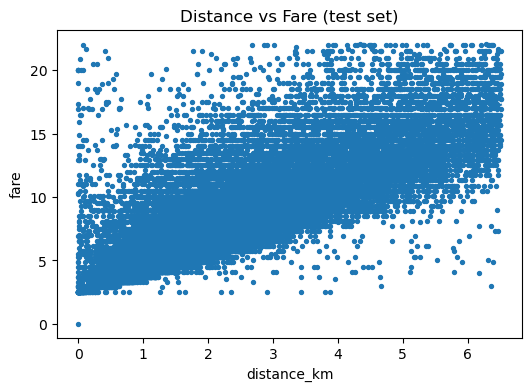

In [19]:
plt.figure(figsize=(6,4))
plt.scatter(X_test["distance_km"], y_test, s=8)
med_pass = X_test["passengers"].median()
xs = np.linspace(X_test["distance_km"].min(), X_test["distance_km"].max(), 50)
ys_line = lr.intercept_ + lr.coef_[0]*xs + lr.coef_[1]*med_pass
plt.plot(xs, ys_line)
plt.xlabel("distance_km"); plt.ylabel("fare")
plt.title("Distance vs Fare (test set)")
plt.show()